In [75]:
import os
from matplotlib import test
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import models,layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing import image

train='archive/Forest Fire Dataset/Training'
test='archive/Forest Fire Dataset/Testing'

batch_size=32
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen= image.ImageDataGenerator( rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
    test,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'binary')
class_names=train_generator.class_indices.keys()
class_names



Found 1520 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


dict_keys(['fire', 'nofire'])

In [76]:
base_for_model = densenet.DenseNet201(weights='imagenet', input_shape=(224,224,3), include_top=False, classes=2, classifier_activation=Softmax)
for layer in base_for_model.layers:
    layer.trainable = False

In [77]:
model = Sequential()
model.add(base_for_model) 
model.add(GaussianNoise(0.25)) #to prevent overfitting
model.add(GlobalAveragePooling2D()) #to converge and reduce the parameters
model.add(Dense(512, activation = 'relu')) #hidden layer (relu activation function is suggested for images)
model.add(BatchNormalization()) #to prevent overfitting
model.add(Dense(1, activation='sigmoid')) #output layer
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 gaussian_noise_8 (GaussianN  (None, 7, 7, 1920)       0         
 oise)                                                           
                                                                 
 global_average_pooling2d_8   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 512)               983552    
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                      

In [78]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC']
)
mp= tf.keras.callbacks.ModelCheckpoint(filepath='mymodel.hdf5', verbose=2, save_best_only=True)
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)
callback=[es,mp]

In [79]:
history=model.fit(
    train_generator,
    epochs=5,
    batch_size=batch_size,
    callbacks=callback,
    validation_data=test_generator
)

Epoch 1/5
48/48 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9539 - precision: 0.9551 - recall: 0.9526 - auc: 0.9893
Epoch 1: val_loss improved from inf to 0.33816, saving model to mymodel.hdf5
48/48 [==============================] - 40s 588ms/step - loss: 0.1325 - accuracy: 0.9539 - precision: 0.9551 - recall: 0.9526 - auc: 0.9893 - val_loss: 0.3382 - val_accuracy: 0.9079 - val_precision: 1.0000 - val_recall: 0.8158 - val_auc: 0.9786
Epoch 2/5
48/48 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9697 - precision: 0.9722 - recall: 0.9671 - auc: 0.9932
Epoch 2: val_loss improved from 0.33816 to 0.14089, saving model to mymodel.hdf5
48/48 [==============================] - 23s 465ms/step - loss: 0.0960 - accuracy: 0.9697 - precision: 0.9722 - recall: 0.9671 - auc: 0.9932 - val_loss: 0.1409 - val_accuracy: 0.9711 - val_precision: 1.0000 - val_recall: 0.9421 - val_auc: 0.9874
Epoch 3/5
48/48 [==============================] - ETA: 0s - l

In [83]:
score = model.evaluate(test_generator)

12/12 [==============================] - 4s 305ms/step - loss: 0.0800 - accuracy: 0.9763 - precision: 0.9892 - recall: 0.9632 - auc: 0.9949


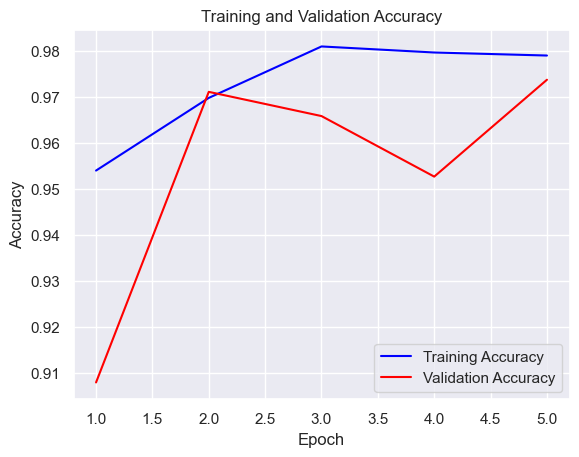

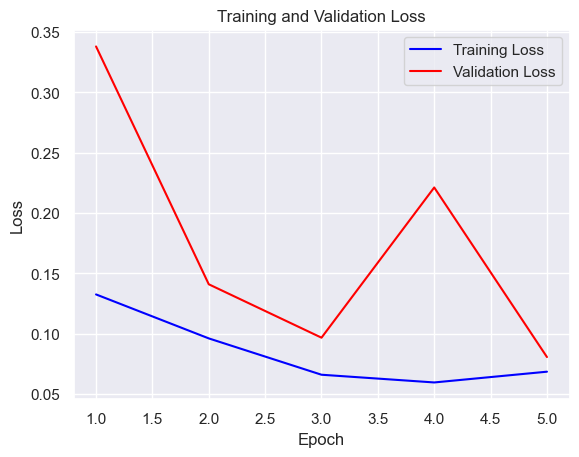

In [80]:
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='red', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

12/12 [==============================] - 7s 318ms/step


<AxesSubplot: >

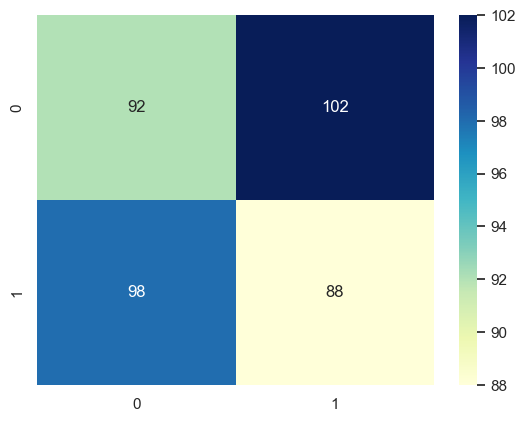

In [81]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_generator)
#test_generator.classes
cm = confusion_matrix( predictions.round(),test_generator.classes)

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

1/1 [==============================] - 0s 45ms/step
No_Fire


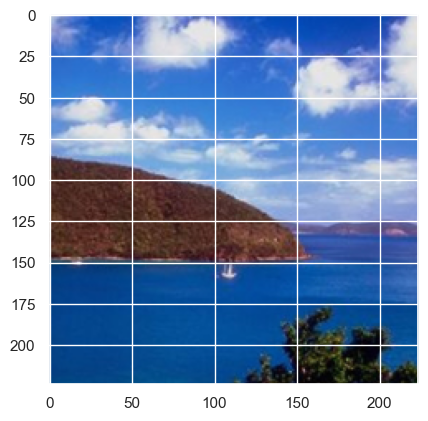

In [84]:
import cv2
input = plt.imread("archive/Forest Fire Dataset/Training/nofire/nofire_0011.jpg")
image = cv2.resize(input,(224,224))
img = np.expand_dims(image, axis=0)
score = model.predict(img)
output = score.round()
if output==0:
    print("Fire")
else:
    print("No_Fire")
plt.imshow(image)